In [2]:
#####################################################################

In [3]:
import numpy as np
import random
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm as _tqdm
import gym
import argparse
import copy
from gridworld import GridworldEnv
from tqdm import tqdm
import pickle
import itertools

from contextlib import contextmanager
import sys, os

from DQN_model import QNetwork
from DQN_replay import ReplayMemory
from DQN_policy import EpsilonGreedyPolicy, get_epsilon
from DQN_training import train
from DQN_plots import plot_smooth
from DQN_main import run_episodes

In [4]:
# From https://stackoverflow.com/questions/2125702/how-to-suppress-console-output-in-python
@contextmanager
def suppress_stdout(suppress):
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        if suppress:
            sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [77]:
listi = [1, 2, 3]
# print(itertools.cycle(listi)[4])

In [ ]:
def bin_lst(lst, halfbin=10):
    avgd = []
    for i in range(len(lst)):
        if i < halfbin:
            avgd.append(np.mean(lst[:i*2+1]))
        elif len(lst)-1-i < halfbin:
            diff = len(lst)-1-i
            avgd.append(np.mean(lst[i-diff:]))
        else:
            avgd.append(np.mean(lst[i-halfbin:i+halfbin]))
    return avgd

In [86]:
def plot_with_error(losses, unc=True, filename=None, plot_label="Loss", y_label="Loss", colour='blue',
                    fig_in=None, red_line=None, mean_only=False, lw=2, bin_it=None):
    losses = np.array(losses)

    
    means = np.mean(losses, axis=0)
    errors = np.std(losses, axis=0)
    
    if bin_it is not None:
        means = bin_lst(means, halfbin=bin_it)
        errors = bin_lst(errors, halfbin=bin_it)
    
    if unc: # Plot uncertainty instead of std
        errors = errors / np.sqrt(losses.shape[0])
    
    x = np.arange(len(means))
    if fig_in is None:
        fig, ax = plt.subplots(1)
        if red_line is not None:
            plt.axhline(y=red_line, color='r', linestyle='-')
    else:
        fig, ax = fig_in
    ax.plot(x, means, lw=2, label=f"Mean {plot_label}", color=colour, linewidth=lw)
    if not mean_only:
        ax.fill_between(x, means+errors, means-errors, facecolor=colour, alpha=0.5)
    if fig_in is None:
        ax.legend(loc='upper left', fancybox=True)
    ax.set_xlabel('Episodes')
    ax.set_ylabel(y_label)
    
    
    
    ax.grid()
    if fig_in is not None:
        return fig, ax
    if filename is not None:
        save_path = '../plots/'
        if not os.path.isdir(save_path):
            os.mkdir(save_path)
                
        plt.savefig(f"{save_path}/{filename}.pdf", format='pdf')
        
def plot_multiple(multiple_losses, labels, filename=None, y_label="Loss",
                  red_line=None, br=False, legend_off=False, mean_only=False, title=None, lw=2,bin_it=None): # Assumes multiple losses contains a set of loss_list's for each parameter
    # File prepends should be a list of names
    colours = ['b', 'g', 'y', 'm', 'c', 'k', 'w']
    fig, ax = plt.subplots()
    if title is not None:
        plt.title(title)
    if red_line is not None:
        plt.axhline(y=red_line, color='r', linestyle='-')
    for (losses, colour, label) in zip(multiple_losses, colours, labels):
        plot_with_error(losses, unc=True, plot_label=label, y_label=y_label, colour=colour,
                        fig_in = (fig,ax), red_line=red_line, mean_only=mean_only, lw=lw, bin_it=bin_it)
    
    ax.grid()
    if br and not legend_off:
        ax.legend(loc='lower right', fancybox=True)
    elif not legend_off:
        ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), fancybox=True)
    if filename is not None:
        save_path = '../plots/'
        if not os.path.isdir(save_path):
            os.mkdir(save_path)
                
        plt.savefig(f"{save_path}/{filename}.pdf", format='pdf')

In [56]:
def pickle_tuple(tupl, filename='test'):
    save_path = '../pickles/'
    if not os.path.isdir(save_path):
        os.mkdir(save_path)
    with open(f"{save_path}/{filename}.pkl", 'wb') as f:
        pickle.dump(tupl,f)

def unpickle_tuple(filename='test'):
    save_path = '../pickles/'
    if not os.path.isdir(save_path):
        os.mkdir(save_path)
    with open(f"{save_path}/{filename}.pkl", 'rb') as f:
        return pickle.load(f)

In [8]:
def run_setting(env_name, num_episodes, batch_size, memory_size, discount_factor, learn_rate, seed, num_hidden, 
                min_eps, max_eps, anneal_time, clone_interval, clipping, suppress_printing):
    # mostly copied from main() in DQN_main.py, removed some code for overview
    # if you want replay to be turned off, use batch_size=memory_size=1
    # returns episode durations (list), losses averaged per step (list), max abs q averaged per step (list)
    
    env = GridworldEnv() if env_name == "GridWorldEnv" else gym.make(env_name)

    obs_shape = env.observation_space.shape
    num_actions = env.action_space.n
    if env_name == "Blackjack-v0":
        obs_size = 3
    elif len(obs_shape) > 0: 
        obs_size = obs_shape[0]
    else:
        obs_size = 1
#     obs_size = obs_shape[0] if len(obs_shape) > 0 else 1

    memory = ReplayMemory(memory_size)

    # for reproducibility
    random.seed(seed)
    torch.manual_seed(seed)
    env.seed(seed)

    Q_net = QNetwork(obs_size, num_actions, num_hidden=num_hidden)
    policy = EpsilonGreedyPolicy(Q_net, num_actions)
    with suppress_stdout(suppress_printing):
        return run_episodes(train, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, 
                            learn_rate, clone_interval, min_eps, max_eps, anneal_time, clipping)

In [9]:
# Replay OFF, Target Network OFF
settings = {
    'env_name':"CartPole-v1",
    'num_episodes':300,
    'batch_size':1, 
    'memory_size':1, 
    'discount_factor':0.8, 
    'learn_rate':1e-3, 
    'num_hidden':128, 
    'min_eps':0.05, 
    'max_eps':1., 
    'anneal_time':1000, 
    'clone_interval':None, 
    'clipping':True,
    'suppress_printing':True
}

start_ = time.time()
durations_list_rF_tF, losses_list_rF_tF, max_Qs_list_rF_tF = [], [], []
for seed in tqdm(range(1,11)):
    durations, losses, max_Qs = run_setting(**settings, seed=seed)
    durations_list_rF_tF.append(durations)
    losses_list_rF_tF.append(losses)
    max_Qs_list_rF_tF.append(max_Qs)
filename = f"CartPole-v1_replay_off_tn_off"
pickle_tuple((durations_list_rF_tF, losses_list_rF_tF, max_Qs_list_rF_tF, settings), filename=filename)
print((time.time() - start_)/60, "min")

  0%|          | 0/10 [00:00<?, ?it/s]/Users/Yke/Desktop/AI/Year2/RL/venv/miniconda3/envs/rl2020/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/Users/Yke/Desktop/AI/Year2/RL/reproducibility-lab/DQN-Experiments/scripts/DQN_model.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)  # Seems like this does nothing, even when numpy gets passed into Q
100%|██████████| 10/10 [04:17<00:00, 28.29s/it]

4.284290651480357 min


In [11]:
# Replay ON, Target Network OFF
settings = {
    'env_name':"CartPole-v1",
    'num_episodes':300,
    'batch_size':64, 
    'memory_size':50000, 
    'discount_factor':0.8, 
    'learn_rate':1e-3, 
    'num_hidden':128, 
    'min_eps':0.05, 
    'max_eps':1., 
    'anneal_time':1000, 
    'clone_interval':None, 
    'clipping':True,
    'suppress_printing':True
}

start_ = time.time()
durations_list_rT_tF, losses_list_rT_tF, max_Qs_list_rT_tF = [], [], []
for seed in tqdm(range(1,11)):
    durations, losses, max_Qs = run_setting(**settings, seed=seed)
    durations_list_rT_tF.append(durations)
    losses_list_rT_tF.append(losses)
    max_Qs_list_rT_tF.append(max_Qs)
filename = f"CartPole-v1_replay_on_tn_off"
pickle_tuple((durations_list_rT_tF, losses_list_rT_tF, max_Qs_list_rT_tF, settings), filename=filename)
print((time.time() - start_)/60, "min")

100%|██████████| 10/10 [18:52<00:00, 119.06s/it]

18.87795786857605 min


In [21]:
# Replay OFF, Target Network ON
settings = {
    'env_name':"CartPole-v1",
    'num_episodes':300,
    'batch_size':1, 
    'memory_size':1, 
    'discount_factor':0.8, 
    'learn_rate':1e-3, 
    'num_hidden':128, 
    'min_eps':0.05, 
    'max_eps':1., 
    'anneal_time':1000, 
    'clone_interval':10, 
    'clipping':True,
    'suppress_printing':True
}

start_ = time.time()
durations_list_rF_tT, losses_list_rF_tT, max_Qs_list_rF_tT = [], [], []
for seed in tqdm(range(1,11)):
    durations, losses, max_Qs = run_setting(**settings, seed=seed)
    durations_list_rF_tT.append(durations)
    losses_list_rF_tT.append(losses)
    max_Qs_list_rF_tT.append(max_Qs)
filename = f"CartPole-v1_replay_off_tn10_on"
pickle_tuple((durations_list_rF_tT, losses_list_rF_tT, max_Qs_list_rF_tT, settings), filename=filename)
print((time.time() - start_)/60, "min")

100%|██████████| 10/10 [03:10<00:00, 21.59s/it]

3.170945715904236 min


In [22]:
# Replay ON, Target Network ON
settings = {
    'env_name':"CartPole-v1",
    'num_episodes':300,
    'batch_size':64, 
    'memory_size':50000, 
    'discount_factor':0.8, 
    'learn_rate':1e-3, 
    'num_hidden':128, 
    'min_eps':0.05, 
    'max_eps':1., 
    'anneal_time':1000, 
    'clone_interval':10, 
    'clipping':True,
    'suppress_printing':True
}

start_ = time.time()
durations_list_rT_tT, losses_list_rT_tT, max_Qs_list_rT_tT = [], [], []
for seed in tqdm(range(1,11)):
    durations, losses, max_Qs = run_setting(**settings, seed=seed)
    durations_list_rT_tT.append(durations)
    losses_list_rT_tT.append(losses)
    max_Qs_list_rT_tT.append(max_Qs)
filename = f"CartPole-v1_replay_on_tn10_on"
pickle_tuple((durations_list_rT_tT, losses_list_rT_tT, max_Qs_list_rT_tT, settings), filename=filename)
print((time.time() - start_)/60, "min")

100%|██████████| 10/10 [20:31<00:00, 124.35s/it]

20.526058399677275 min


In [79]:
t_settings = ["10","100","1k","10k","50k"]
data = {"r-on":{},"r-off":{}}
for r_setting in ["on", "off"]:
    for t_setting in ["10","100","1k","10k","50k"]:
        fname = f"CartPole-v1_replay_{r_setting}_tn{t_setting}_on"
        data[f"r-{r_setting}"][f"t-{t_setting}"] = unpickle_tuple(filename=fname)
rF_tF = unpickle_tuple(filename=f"CartPole-v1_replay_off_tn_off")
rT_tF = unpickle_tuple(filename=f"CartPole-v1_replay_on_tn_off")

/Users/Yke/Desktop/AI/Year2/RL/venv/miniconda3/envs/rl2020/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.


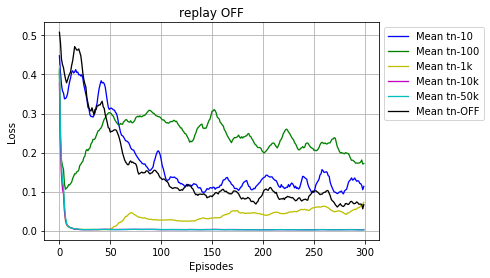

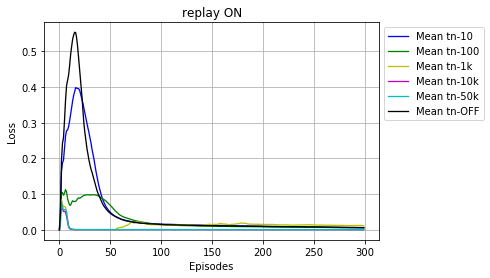

In [93]:
i = 1
ylabels = ["Durations", "Loss", "max|Q|"]

#(durations, losses, max_Qs, settings)
rF_data = [data[f"r-off"][f"t-{t}"][i] for t in t_settings]
plot_multiple(rF_data+[rF_tF[i]], [f"tn-{t}" for t in t_settings+["OFF"]], 
              y_label=ylabels[i], mean_only=True, title="replay OFF", lw=1.3, bin_it=4)

rT_data = [data[f"r-on"][f"t-{t}"][i] for t in t_settings]
plot_multiple(rT_data+[rT_tF[i]], [f"tn-{t}" for t in t_settings+["OFF"]],
              y_label=ylabels[i], mean_only=True, title="replay ON", lw=1.3, bin_it=4)

In [ ]:
###########################################################################